In [1]:
# import required libiraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cycler import cycler
from mplsoccer.pitch import Pitch
from scipy import stats
from scipy.spatial import ConvexHull

%matplotlib inline
%config Completer.use_jedi = False


## Convex Hull

### Convex hull is a one way we use to describe/visualize  a team defensive action, convex hulls display the smallest area needed to cover a set of points. we chart each player in the team together to see area where a team is being forced to defend. 

In [23]:
# read data 

df = pd.read_csv('convextutorial.csv')
df

,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
0,2,0,0.0,65,0.0,0.0,NaN,Start,32
1,2,0,0.0,833,0.0,0.0,NaN,Start,32
2,3,0,1.0,833,50.8,51.5,303800.0,Pass,1
3,4,0,4.0,833,28.4,58.4,316957.0,Pass,1
4,5,0,7.0,833,66.6,24.7,303800.0,BallTouch,61
...,...,...,...,...,...,...,...,...,...
1576,1018,92,7.0,65,0.0,0.0,NaN,End,30
1577,1019,0,0.0,65,0.0,0.0,NaN,End,30
1578,676,0,0.0,833,0.0,0.0,NaN,End,30
1579,1,0,0.0,65,0.0,0.0,NaN,FormationSet,34


### lets do some EDA

In [24]:
# check number of teams

df.teamId.value_counts()

65     960
833    621
Name: teamId, dtype: int64

In [25]:
# fill NaN with 0
df = df.fillna(0)
df.head()

,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
0,2,0,0.0,65,0.0,0.0,0.0,Start,32
1,2,0,0.0,833,0.0,0.0,0.0,Start,32
2,3,0,1.0,833,50.8,51.5,303800.0,Pass,1
3,4,0,4.0,833,28.4,58.4,316957.0,Pass,1
4,5,0,7.0,833,66.6,24.7,303800.0,BallTouch,61


In [26]:
# change playerId to integers

df.playerId = df.playerId.astype(int)
df.head()

,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
0,2,0,0.0,65,0.0,0.0,0,Start,32
1,2,0,0.0,833,0.0,0.0,0,Start,32
2,3,0,1.0,833,50.8,51.5,303800,Pass,1
3,4,0,4.0,833,28.4,58.4,316957,Pass,1
4,5,0,7.0,833,66.6,24.7,303800,BallTouch,61


In [27]:
# selct only teamId = 65 

df_65 = df[df['teamId'] == 65].reset_index()
df_65

,index,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
0,0,2,0,0.0,65,0.0,0.0,0,Start,32
1,5,3,0,8.0,65,27.9,80.6,5,BallRecovery,49
2,6,4,0,9.0,65,30.6,64.3,5,Pass,1
3,7,5,0,13.0,65,26.4,22.4,28,Pass,1
4,8,6,0,18.0,65,29.2,37.7,4,Pass,1
...,...,...,...,...,...,...,...,...,...,...
955,1569,1016,92,3.0,65,92.2,63.0,17,Dispossessed,50
956,1574,1017,92,6.0,65,75.6,83.5,5,Interception,8
957,1576,1018,92,7.0,65,0.0,0.0,0,End,30
958,1577,1019,0,0.0,65,0.0,0.0,0,End,30


In [28]:
# create a list of players

players = df_65.playerId.unique()

# create a list of starting 11 players

starters = players[1:12]

len(players), len(starters)

(14, 11)

In [29]:
players, starters

(array([ 0,  5, 28,  4, 23,  7, 11, 21,  1,  9, 18, 16, 17, 12]),
 array([ 5, 28,  4, 23,  7, 11, 21,  1,  9, 18, 16]))

In [30]:
# change x, y to proper pitch size

df_65['x']  = df_65['x'] * 1.2
df_65['y']  = df_65['y'] * 0.8

df_65.head()

,index,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
0,0,2,0,0.0,65,0.00,0.00,0,Start,32
1,5,3,0,8.0,65,33.48,64.48,5,BallRecovery,49
2,6,4,0,9.0,65,36.72,51.44,5,Pass,1
3,7,5,0,13.0,65,31.68,17.92,28,Pass,1
4,8,6,0,18.0,65,35.04,30.16,4,Pass,1


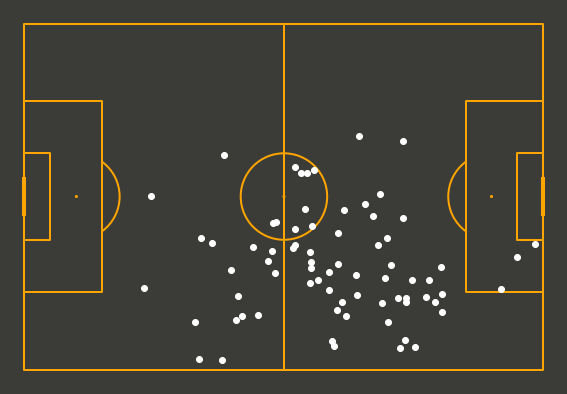

In [31]:
# draw pitch

fig, ax = plt.subplots(figsize = (12, 7))

fig.set_facecolor('#3b3b38')
ax.patch.set_facecolor('#3b3b38')

pitch = Pitch(pitch_type='statsbomb', pitch_color='#3b3b38', line_color='orange')
pitch.draw(ax = ax, tight_layout=True,constrained_layout=False, figsize = (13,8))
plt.gca().invert_yaxis()


# create df for only one player passes only

df1 = df_65[df_65['playerId'] == 21] # de long
df1 = df1[df1 ['type/displayName'] == 'Pass'] # only passes

# lets plot the passes position

plt.scatter (df1.x, df1.y, color = 'w')


In [32]:
df1

,index,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
17,40,19,1,40.0,65,40.32,2.32,21,Pass,1
48,90,54,4,34.0,65,76.56,21.84,21,Pass,1
103,192,115,10,22.0,65,70.44,22.64,21,Pass,1
111,210,123,11,39.0,65,88.32,16.56,21,Pass,1
116,231,128,12,14.0,65,48.96,11.44,21,Pass,1
...,...,...,...,...,...,...,...,...,...,...
895,1480,953,85,40.0,65,82.68,15.36,21,Pass,1
920,1518,980,88,3.0,65,73.44,15.60,21,Pass,1
928,1527,988,88,27.0,65,118.08,29.04,21,Pass,1
940,1550,1000,90,53.0,65,49.44,16.96,21,Pass,1


In [33]:
# as we can see we have some outliers
# to remove this outliers we use standard deviation keep only points that are less than 2 or 3 off the SD

df1 = df1[(np.abs(stats.zscore(df1[['x', 'y']] )) < 4)]

#df1 = df1[(np.abs(stats.zscore(df1[['x','y']])) < 3)]

In [34]:
df1

,index,eventId,minute,second,teamId,x,y,playerId,type/displayName,type/value
17,40,19,1,40.0,65,40.32,2.32,21,Pass,1
17,40,19,1,40.0,65,40.32,2.32,21,Pass,1
48,90,54,4,34.0,65,76.56,21.84,21,Pass,1
48,90,54,4,34.0,65,76.56,21.84,21,Pass,1
103,192,115,10,22.0,65,70.44,22.64,21,Pass,1
...,...,...,...,...,...,...,...,...,...,...
928,1527,988,88,27.0,65,118.08,29.04,21,Pass,1
940,1550,1000,90,53.0,65,49.44,16.96,21,Pass,1
940,1550,1000,90,53.0,65,49.44,16.96,21,Pass,1
952,1566,1013,91,54.0,65,87.48,34.96,21,Pass,1


### To create a convex hull, we need to build it from a list of coordinates. We have our coordinates in the dataframe already, but need them to look something close to the below:

### (38.9, 31.8), (30.0, 33.2), (64.7, 94.9) so we use .values

In [35]:
# create array of x,y points values

points = df1[['x', 'y']].values

In [36]:
hull = ConvexHull(df1[['x', 'y']])

### we’re going to add lines around the most extreme parts of the plot. These most extreme parts are stored in a part of the hull object called simplices. We can just use a for loop to iterate through the simplices and draw lines between them:

In [37]:
hull.simplices

array([[ 66,  64],
       [128, 140],
       [128,  22],
       [  1,  64],
       [ 58, 140],
       [ 58,  42],
       [132,  22],
       [132,  66],
       [120,   1],
       [ 55,  42],
       [ 55, 120]], dtype=int32)

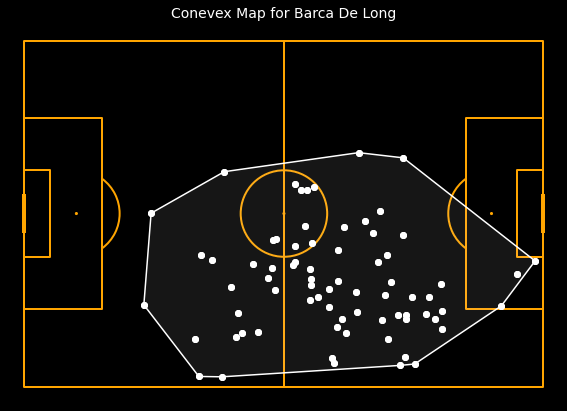

In [38]:
# now lets draw again

fig, ax = plt.subplots(figsize = (12, 7))

fig.set_facecolor('black')
ax.patch.set_facecolor('#3b3b38')

pitch = Pitch(pitch_color='black', line_color='orange')
pitch.draw(ax = ax, tight_layout=True)
plt.gca().invert_yaxis()

plt.scatter(df1.x, df1.y, color = 'white')


# use a for loop to plot the line around the points

for i in hull.simplices:
    plt.plot(points[i, 0], points[i, 1], c = 'white') 
    # shade the area 
    plt.fill (points[hull.vertices,0], points[hull.vertices,1], c = 'white', alpha = 0.01)
plt.title ('Conevex Map for Barca De Long', color = 'white', fontsize = 14)
plt.savefig('De Long Convex map.png');

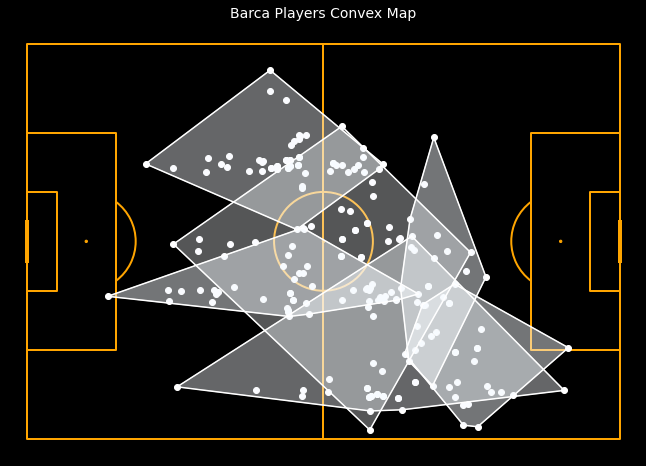

In [39]:
# now lets try to plot the convexhull for all the starters

# now lets draw again

fig, ax = plt.subplots(figsize = (14, 8))

fig.set_facecolor('black')
ax.patch.set_facecolor('#3b3b38')

pitch = Pitch(pitch_color='black', line_color='orange')
pitch.draw(ax = ax, tight_layout=True)
plt.gca().invert_yaxis()


# try different colors

diff = ['red', 'blue', 'green', 'yellow', 'pink', 'navy']

color = iter(cm.Blues_r (np.linspace(0, 1, 6)))
for f in range(6):
   c = next(color)

for player in starters[:6]:
    
    # create df for every player passes only
    df2 = df_65[df_65['playerId'] == player] # 
    df2 = df2[df2 ['type/displayName'] == 'Pass'] # only passes
    
    # remove outliers
    df2 = df2[(np.abs(stats.zscore(df2[['x', 'y']] )) < 0.25)]
    
    # create array of x,y points values
    points = df2[['x', 'y']].values
    
    # creat convex hull if we have enough points
    try:
        hull = ConvexHull(df2[['x', 'y']])
        
    except:
        pass
    plt.scatter(df2.x, df2.y, color = 'w')
    # plot the convex hull
    
    try:
        for i in hull.simplices:
            plt.plot(points[i, 0], points[i, 1], c = 'white') 
            # shade the area 
            plt.fill (points[hull.vertices,0], points[hull.vertices,1], c = c, alpha = 0.1)
            
            
    except:
        pass
    
plt.title('Barca Players Convex Map', c = 'w', fontsize = 14)
plt.savefig('Barca Convex Map.png');
